# Using Slipmap on the Air Quality dataset

In this notebook we will demonstrate how to use `Slipmap` on the Air Quality dataset with a classification task.

Since `Slisemap` and `Slipmap` have almost identical API:s the code will look quite similar to the previous notebook.
The main difference is that `Slipmap` scales better to larger datasets by not giving every data item an unique local model.
Instead, the local models are placed on a regular grid in the embedding.
We will see the gird of "prototypes" in some of the plots below.

In [1]:
import sys

import numpy as np
import pandas as pd

from pathlib import Path
from urllib.request import urlretrieve

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sys.path.insert(0, "..")

from slisemap import Slipmap
from slisemap.local_models import LogisticRegression
from slisemap.metrics import accuracy

### Objectives

These are the objectives of this notebook:

- Demonstrate how to use a different type of white box model with Slipmap.
- Discuss the use of subsampling.
- Demonstrate how to tweak parameters.
- Investigate the solution and the data.
- Demonstrate how to predict unseen data.

## Caching

To reduce execution times, we provide dumps of pretrained Slipmap models. If you want to train them yourself instead please set `USE_CACHE=False`.

In [2]:
USE_CACHE = True
SM_V1_CACHE_PATH = Path("cache") / "02_classification_example_airquality.v1.sp"
SM_V2_CACHE_PATH = Path("cache") / "02_classification_example_airquality.v2.sp"

if USE_CACHE:
    for path in [SM_V1_CACHE_PATH, SM_V2_CACHE_PATH]:
        path.parent.mkdir(exist_ok=True, parents=True)
        if not path.exists():
            urlretrieve(
                f"https://raw.githubusercontent.com/edahelsinki/slisemap/data/examples/cache/{path.name}",
                path,
            )

## Data

The Air Quality dataset contains 7355 hourly instances of 12 different air quality measurements, one of which is used as a dependent variable (CO) and the others as covariates. Since this notebook demonstrates classification, we split the $y$-values into two clusters based on the median.

In [3]:
# As in previous noteboook, load the dataset (download it if necessary).
path = Path("data") / "AQ_cleaned_version.csv"
path.parent.mkdir(exist_ok=True, parents=True)
if not path.exists():
    urlretrieve(
        "https://raw.githubusercontent.com/edahelsinki/drifter/master/TiittanenOHP2019-code/data/AQ_cleaned_version.csv",
        path,
    )
AQ = pd.read_csv(path)

In [4]:
"""
The Air Quality dataset is cleaned and preprocessed as in:

    Oikarinen E, Tiittanen H, Henelius A, Puolamäki K (2021)
    Detecting virtual concept drift of regressors without ground truth values.
    Data Mining and Knowledge Discovery 35(3):726-747, DOI 10.1007/s10618-021-00739-7]
"""
columns = [
    "PT08.S1(CO)", "C6H6(GT)", "PT08.S2(NMHC)", "NOx(GT)", "PT08.S3(NOx)", "NO2(GT)",
    "PT08.S4(NO2)", "PT08.S5(O3)", "T", "RH", "AH",
]
names = [
    "CO(sensor)", "C6H6(GT)", "NMHC(sensor)", "NOx(GT)", "NOx(sensor)", "NO2(GT)",
    "NO2(sensor)", "O3(sensor)", "Temperature", "Relative hum.", "Absolute hum.",
]

# X contains the covariates, y is the target variable and names are column names.
X0 = AQ[columns].to_numpy()
y0 = AQ["CO(GT)"].to_numpy()

In [5]:
pd.DataFrame(np.concatenate([y0.reshape((-1,1)), X0], axis=1), columns=["CO(GT)"]+names)

,CO(GT),CO(sensor),C6H6(GT),NMHC(sensor),NOx(GT),NOx(sensor),NO2(GT),NO2(sensor),O3(sensor),Temperature,Relative hum.,Absolute hum.
0,2.6,1360.00,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.600,48.875001,0.757754
1,2.0,1292.25,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300,47.700000,0.725487
2,2.2,1402.00,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900,53.975000,0.750239
3,2.2,1375.50,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000,60.000000,0.786713
4,1.6,1272.25,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150,59.575001,0.788794
...,...,...,...,...,...,...,...,...,...,...,...,...
7350,3.1,1314.25,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250000,0.756824
7351,2.4,1162.50,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725000,0.711864
7352,2.4,1142.00,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350000,0.640649
7353,2.1,1002.50,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,13.550000,0.513866


In [6]:
# We will now split the target variables to two binary classes
# Straight through the middle based on target median
y = (y0 > np.median(y0)).astype(float)
y = np.stack((y, 1 - y), 1)
scale_x = StandardScaler()
X = scale_x.fit_transform(X0)

### Black box model

Now, as in the previous notebook, we will use a black box model for the target value. For that we build a random forest classifier using `sklearn.ensemble.RandomForestClassifier`. Note that we use the predicted probabilities instead of the predicted labels!

In [7]:
random_forest = RandomForestClassifier(random_state=42).fit(X, y)
y2 = random_forest.predict_proba(X)[0]

## Slipmap

Since we are now dealing with a classification task, we replace the default white box model (linear regression) with logistic regression.
Furthermore, we split the data into 3000 training and 3000 testing items (`Slipmap` can handle larger datasets then `Slisemap`, but for visualisation purposes we don't need a massive amount).

In [8]:
# Subsample the data
size = 3000
X, X_test, y2, y_test = train_test_split(
    X, y2, train_size=size, test_size=size, stratify=y[:, 0], random_state=42
)

Now we create a Slipmap object (without an intercept) and optimise the solution.

In [15]:
if USE_CACHE and SM_V1_CACHE_PATH.exists():
    sm = Slipmap.load(SM_V1_CACHE_PATH, device="cpu")
else:
    # Create a Slipmap object with lasso regularisation
    sm = Slipmap(
        X,
        y2,
        lasso=0.0001,
        radius=2.0,
        intercept=False,
        local_model=LogisticRegression,
    )
    # Optimise the solution
    %time sm.optimise()
    # Store metadata
    sm.metadata.set_variables(names)
    sm.metadata.set_targets(["High CO(GT)", "Low CO(GT)"])
    sm.metadata.set_scale_X(scale_x.mean_, scale_x.scale_)
    # Save the solution
    sm.save(SM_V1_CACHE_PATH)

print(f"Loss: {sm.value()}")

CPU times: user 9min 21s, sys: 612 ms, total: 9min 22s
Wall time: 2min 22s
Loss: 2.0736284255981445


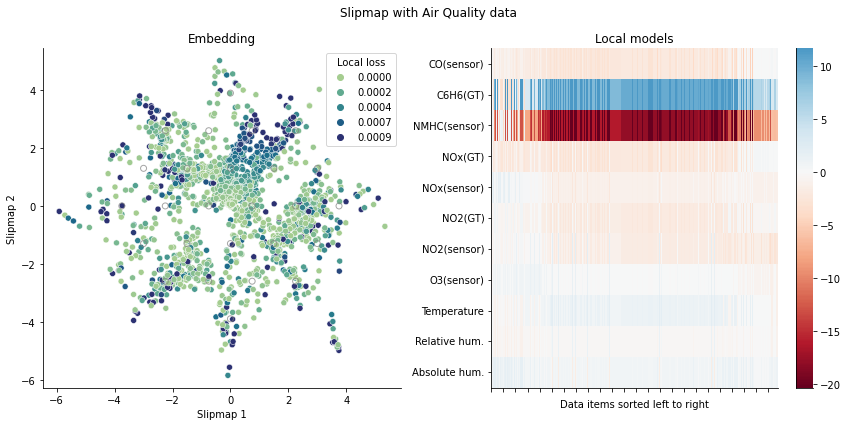

In [17]:
sm.plot(title="Slipmap with Air Quality data")

The data items are shown as the coloured dots in the embedding and the prototypes as empty circles.

### Tweaking

If we plot the solution we see that the linear models are not very sparse even though we used lasso/L1 regularisation.
This is beacuse we used quite weak regularisation. We can increase the regularisation strength without creating a new `Slipmap` object (remember to re-optimise):

In [23]:
if USE_CACHE and SM_V2_CACHE_PATH.exists():
    sm = Slipmap.load(SM_V2_CACHE_PATH, device="cpu")
else:
    sm.lasso = 0.01
    %time sm.optimise()

    sm.save(SM_V2_CACHE_PATH)

CPU times: user 9min 47s, sys: 628 ms, total: 9min 47s
Wall time: 2min 28s


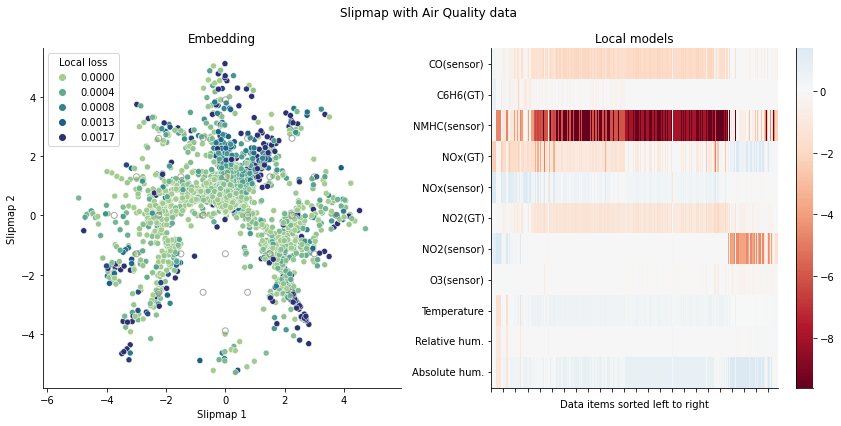

In [24]:
sm.plot(title="Slipmap with Air Quality data")

Now the local models are more sparse (more coefficients are zero). This makes them easier to interpret. Additionally, the clusters in the embedding are more distinct, due to the larger differences in the local models. 

### Visualisations

Next we will plot the local models in a bar plot:

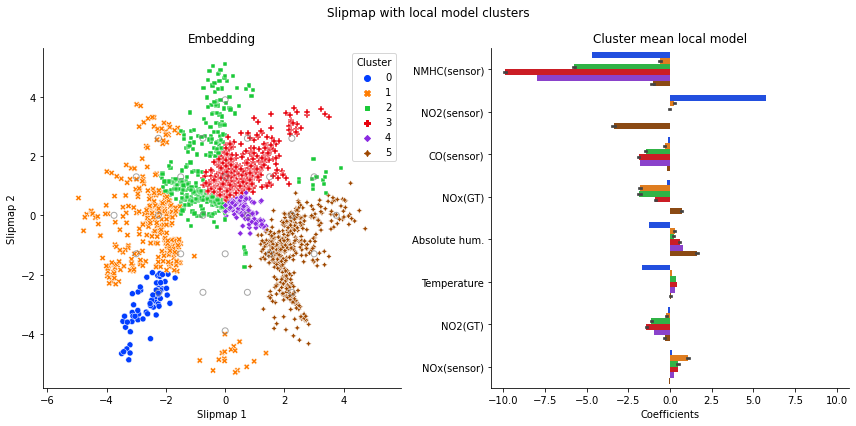

In [29]:
clusters = 6
bars = 8
sm.plot(
    title="Slipmap with local model clusters",
    clusters=clusters,
    bars=bars,
)

This makes it easier to see which clusters and local models are connected, and to compare the magnitudes of the coefficients of the local models.

Next we plot the distribution of attribute values for the clusters (note that the values have been unscaled):

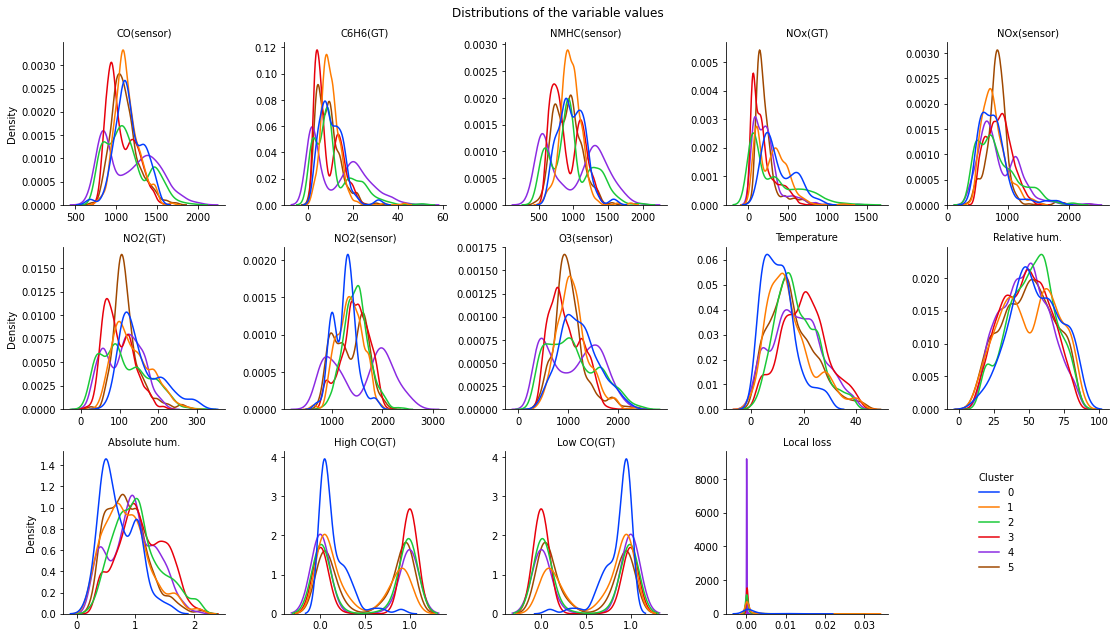

In [34]:
sm.plot_dist(
    title="Distributions of the variable values",
    clusters=clusters,
    height=3,
    col_wrap=5,
)

Here we see that the clusters do not only have different local models, there are also differences in the distributions of the variables.

## Unseen test data

Earlier we subsampled the data into the training set consisting of 3000 data items and the testing set of 3000.
Now we will test how well the trained Slipmap predicts the unseen data.
First we take 7 random test data items and show what their local losses for the different prototypes.

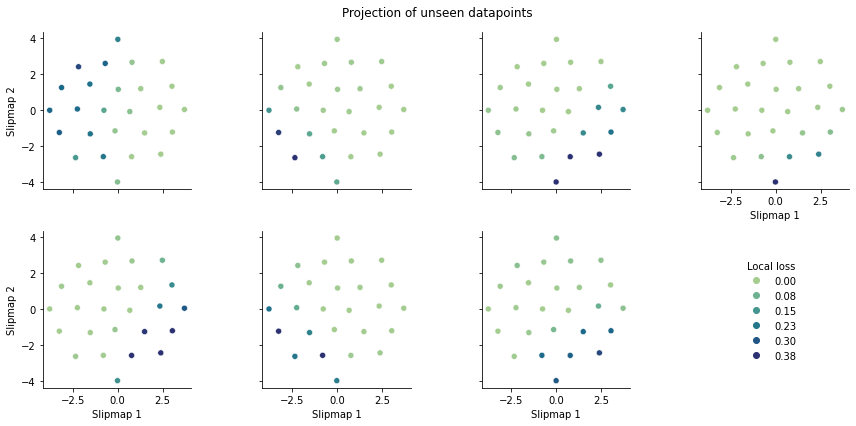

In [36]:
np.random.seed(42)
sel = np.random.randint(0, X_test.shape[0], 7)
sm.plot_position(
    X_test[sel],
    y_test[sel],
    title="Projection of unseen datapoints",
    height=3,
)

Here we see that the local models in the different clusters are not suitable for every unseen data item.
But choosing the the embedding based on this visualisation requires knowing the true $y$, which defeats the purpose of prediction.
Hence we can evaluate the losses when using the `sm.predict` function instead:

In [47]:
# The `accuracy` metric uses the `sm.predict` function that is based selecting the nearest neighbours in X-space
print("Training data local loss:", accuracy(sm, X, y2))
print("Testing data local loss: ", accuracy(sm, X_test, y_test))

Training data local loss: 0.0004158701922278851
Testing data local loss:  0.022573169320821762


The training data obviously has lower loss, but the losses on the testing data is still quite low.

## Conclusions

In this notebook we have looked at a simple classifier use case for Slipmap, and demonstrated the various plots that can be used to to visualise, explore, and investigate the solution and the data.